In [23]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import glob
import cv2
import os
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from imutils import contours
import imutils
import scipy.misc as sm
%matplotlib inline

In [24]:
def predictor(full_image_pred,full_image):
    #img_seq = mpimg.imread(image_path)
    '''img_seq = img_part
    img_seq = np.asarray(img_seq)
    img_seq = img_seq.reshape((1,224,224,3))
    #datagen.fit(img_seq)
    prediction = odmodel.predict(img_seq)
    prediction = np.asarray(prediction)
    #print(prediction.shape)
    prediction = prediction.reshape((1,224,224))
    #print(prediction.shape)
    '''
    image = full_image_pred
    #img_gtp = image
    image[image<190] = 0
    
    cx_cord = []
    cy_cord = []
    w_cord  = []
    h_cord  = []
    x_cord  = []
    y_cord  = []

    #image = cv2.imread('Images_for_FCRN/Random/img1/img1_1gt.jpg')
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)


    thresh = cv2.threshold(blurred, 190, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue


        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if numPixels > 150:
            mask = cv2.add(mask, labelMask)


    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    #image = cv2.imread(image_path)
    image = full_image
    
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        cx_cord.append(cX)
        cy_cord.append(cY)
        h_cord.append(h)
        w_cord.append(w)
        x_cord.append(x)
        y_cord.append(y)
        
        '''RotatedRect box = fitEllipse(c);
        Point2f vtx[4];
        box.points(vtx);
        for( int j = 0; j < 4; j++ )
            line(image, vtx[j], vtx[(j+1)%4], Scalar(0,255,0),2);'''
        
        #rect = cv2.minAreaRect(c)
        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image,[box],0,(255,255,0),1)
            
        #cv2.rectangle(image,(x,y),(x+w,y+h),(255, 0, 255), 3)
        #cv2.circle(image,(int(cX),int(cY)),int(radius/2),(255,0,255),3)
        #cv2.putText(image, "#{}".format(i + 1), (x, y - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
        #print(i)

    plt.imshow(image,vmin = 0, vmax = 255)
    #cv2.imshow("Image", image)
    #cv2.waitKey(0)
    
    
    #for i in range(len(cx_cord)):
        #cv2.circle(image,(int(cx_cord[i]),int(cy_cord[i])),int(2),(255,0,255),3)
        #cv2.rectangle(image,(x_cord[i],y_cord[i]),(x_cord[i]+w_cord[i],y_cord[i]+h_cord[i]),(255, 0, 255), 1)
        #point = []
        #cv2.rectangle(fitEllipse((cx_cord[i],cy_cord[i])))
    
    #plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", len(cx_cord))
    
    return image
    #return img_gtp

In [25]:
odmodel = load_model('aug_inverter_on_all_imagesx5.h5')

In [26]:
full_image = cv2.imread('Images_for_FCRN/Test/11.jpg')
#full_image = cv2.resize(full_image, (224, 224)) 
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

(892, 710, 3)


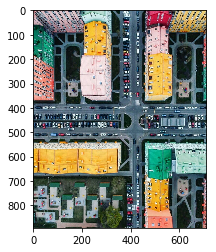

In [27]:
plt.imshow(full_image,vmin = 0,vmax = 255)
print(full_image.shape)

In [28]:
full_image = np.asarray(full_image)
np.amax(full_image[0])

255

In [29]:
def cropper(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    
    return cropped_img

In [17]:
print(full_image.shape)
full_image_p = np.zeros((1888,2512))
print(full_image_p.shape)
#overlap = np.zeros((3808,5824,3))

(1888, 2512, 3)
(1888, 2512)


In [18]:
def place(prediction,full_image_p,y,x):
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])
    #full_image_p[y: y + 224,x: x + 224] = max(full_image[y: y + 224,x: x + 224],prediction)

In [19]:
for x in range(12):
    #partial_p = []
    for y in range(9):
        img_part = cropper(full_image,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
        '''if y==0 and x==1:
            plt.imshow(img_part,vmin = 0,vmax = 255)
            img_part = np.asarray(img_part)
            print(img_part.shape)
        '''
        img_part = np.asarray(img_part)
        img_part = img_part.reshape((1,224,224,3))
        #datagen.fit(img_seq)
        img_part = 255 - img_part
        prediction = odmodel.predict(img_part)
        prediction = np.asarray(prediction)
        #print(prediction.shape)
        print(x," ",y)
        prediction = prediction.reshape((1,224,224))
        place(prediction,full_image_p,y*208,x*208)
        #full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]  
        
        

0   0
0   1
0   2
0   3
0   4
0   5
0   6
0   7
0   8
1   0
1   1
1   2
1   3
1   4
1   5
1   6
1   7
1   8
2   0
2   1
2   2
2   3
2   4
2   5
2   6
2   7
2   8
3   0
3   1
3   2
3   3
3   4
3   5
3   6
3   7
3   8
4   0
4   1
4   2
4   3
4   4
4   5
4   6
4   7
4   8
5   0
5   1
5   2
5   3
5   4
5   5
5   6
5   7
5   8
6   0
6   1
6   2
6   3
6   4
6   5
6   6
6   7
6   8
7   0
7   1
7   2
7   3
7   4
7   5
7   6
7   7
7   8
8   0
8   1
8   2
8   3
8   4
8   5
8   6
8   7
8   8
9   0
9   1
9   2
9   3
9   4
9   5
9   6
9   7
9   8
10   0
10   1
10   2
10   3
10   4
10   5
10   6
10   7
10   8
11   0
11   1
11   2
11   3
11   4
11   5
11   6
11   7
11   8


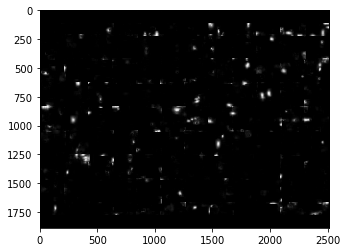

In [21]:
plt.imshow(full_image_p,cmap='gray',vmin = 0,vmax = 255)
#sm.imsave('1pred(o=16)_full_aug.JPG',full_image_p)

Total cars predicted =  19


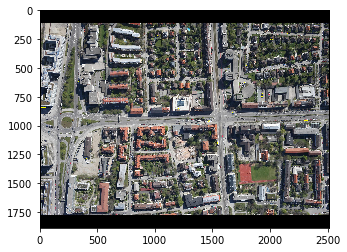

In [22]:
bounded_image = predictor(full_image_p,full_image)

In [13]:
sm.imsave('1PRED(o=16)_full_aug.JPG',bounded_image)


/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [68]:
sm.imsave('1pred_gt.JPG',full_image_p)
full_image_p = np.asarray(full_image_p)
print(full_image_p.shape)


/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


(5824, 3808)


/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


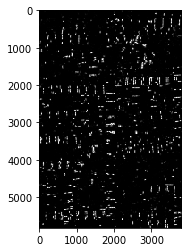

In [69]:
#full_image_p = full_image_p.reshape(5824,3808)
#full_image_p = full_image_p.T
sm.imsave('1pred_gt.JPG',full_image_p)
plt.imshow(full_image_p,cmap = 'gray',vmin = 0,vmax = 255)

Total cars predicted =  598


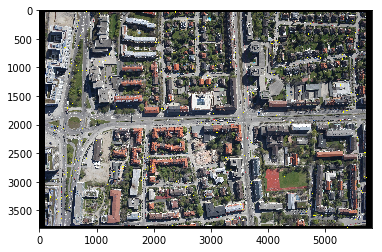

In [50]:
full_image_predicted = predictor(full_image_p,full_image)

In [51]:
sm.imsave('1pred.JPG',full_image_predicted)

/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
